In [2]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import os
import torch.optim.lr_scheduler as lr_scheduler
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from PIL import Image
import scipy.io

np.random.seed(2345)
torch.manual_seed(1234)
# CUDA
# if gpu is available
if torch.cuda.is_available():
    device = torch.device('cuda')
    print("CUDA is available")
else:
    device = torch.device('cpu')
    print("Only cpu is available")
    
torch.backends.cudnn.benchmark = True
epsilon = torch.finfo(torch.float32).eps

CUDA is available


In [3]:
class DNN1(torch.nn.Module):
    def __init__(self, width, out_layer):
        super(DNN1, self).__init__()
        self.width = width
        self.p = nn.Conv2d(2, self.width, 1) # 输入通道；输出通道；卷积核大小
        self.mlp1 = nn.Conv2d(self.width, self.width, 1) 
        self.mlp2 = nn.Conv2d(self.width, self.width, 1)
        self.mlp3 = nn.Conv2d(self.width, self.width, 1) 
        self.mlp4 = nn.Conv2d(self.width, self.width, 1) 
        self.q = nn.Conv2d(self.width, out_layer, 1)
        self.norm = nn.InstanceNorm2d(self.width)
        self.a = nn.Parameter(torch.tensor(0.2))
        
    def forward(self, x):
        x = x.permute(0, 3, 1, 2) # (A,B,C,D)->(A,D,B,C)
        x = self.p(x)
        x = 5 * self.a * x #可google自适应激活函数
        x = torch.tanh(x)
        
        x = self.mlp1(x)
        x = 5 * self.a * x
        x = torch.tanh(x)
        
        x = self.mlp2(x)
        x = 5 * self.a * x
        x = torch.tanh(x)
        
        x = self.mlp3(x)
        x = 5 * self.a * x
        x = torch.tanh(x)
        
        x = self.mlp4(x)
        x = 5 * self.a * x
        x = torch.tanh(x)
        
        x = self.q(x)
        return x 

In [12]:
class PhysicsInformedNN1:
    def __init__(self, ref_gray_matrix, def_gray_matrix, ROI, width, outlayer, IX, IY):
        self.Iref = torch.tensor(ref_gray_matrix, dtype=torch.float32).to(device)
        self.Idef = torch.tensor(def_gray_matrix, dtype=torch.float32).to(device)
        self.roi = torch.tensor(ROI, dtype=torch.float32).to(device)
        self.ROI = ROI
        self.IX = torch.tensor(IX, dtype=torch.float32).to(device)
        self.IY = torch.tensor(IY, dtype=torch.float32).to(device)
        self.XY = torch.stack((self.IX, self.IY), dim=2).unsqueeze(0)
        # 误差图汉明窗设置
        self.window_size = 3 # 汉明窗大小为奇数
        self.window = torch.hann_window(self.window_size).to(device)
        self.twoD = True # true：采用二维汉明窗，false：采用一维汉明窗
        # 加载深度学习网络
        self.dnn = DNN1(width,outlayer[0]).to(device)
        self.dnn_k = DNN1(width,outlayer[1]).to(device)
        self.dnn_b = DNN1(width,outlayer[1]).to(device)
        
        self.epoch = 0
        self.loss_temp=100
        self.loss_list = []
        self.lossf_list = []
        parameters_to_optimize = list(self.dnn.parameters()) + list(self.dnn_k.parameters()) # + list(self.dnn_b.parameters())
        # 设置优化器
        self.optimizer = torch.optim.LBFGS(parameters_to_optimize, lr=1, max_iter=2000, max_eval=50000,
                                           history_size=100, tolerance_grad=1e-08, tolerance_change=0.5 * np.finfo(float).eps,
                                           line_search_fn="strong_wolfe")
        
        self.optimizer_adam = torch.optim.Adam(parameters_to_optimize, lr=0.001,  eps=1e-8, weight_decay=0.0001)
 
    def smooth_hm(self, loss, twoD=False):
        matrix = loss
        if twoD == True:
            window_2d = self.window.outer(self.window) 
            smoothed_matrix = F.conv2d(matrix.unsqueeze(0).unsqueeze(0), 
                                       window_2d.unsqueeze(0).unsqueeze(0), 
                                       padding=self.window_size // 2)
        else:
            window_1d = self.window
            smoothed_matrix = F.conv1d(matrix.view(1, 1, -1), 
                                       window_1d.view(1, 1, -1), 
                                       padding=self.window_size // 2)
            smoothed_matrix = smoothed_matrix.view(matrix.size())
        return smoothed_matrix
    
    def set_window(self, window_size, flag=False):
        self.window_size = window_size
        self.window = torch.hann_window(self.window_size).to(device)
        self.twoD = flag

    def interpolation(self, UV, k, b):
        u = UV[0,0]/self.Iref.shape[1]; v = UV[0,1]/self.Iref.shape[0]
        k[:,0,:,:] = k[:,0,:,:]/self.Iref.shape[1]; k[:,1,:,:] = k[:,1,:,:]/self.Iref.shape[0]
        b[:,0,:,:] = b[:,0,:,:]/self.Iref.shape[1]; b[:,1,:,:] = b[:,1,:,:]/self.Iref.shape[0]
        N = self.Idef.shape[0]
        for i in range(N):
            u_new = u #+ k[0,0]*(i-2) #+b[0,0]*(i!=0)
            v_new = v #+ k[0,1]*(i-2) #+b[0,1]*(i!=0)
            uv_new = torch.stack((u, v), dim=2).unsqueeze(0)
            X_new = self.XY + uv_new
            H = self.Iref.shape[0]; L = self.Iref.shape[1];
            new_Idef = F.grid_sample(self.Iref.view(1, 1, H, L), X_new.view(1, H, L, 2), 
                                     mode='bilinear', align_corners=True)
            if i==0:
                DG = new_Idef
            else:
                DG = torch.cat((DG, new_Idef), dim=1)
        return DG     
     
    def loss_fn1(self):
        self.optimizer.zero_grad()
        UV = self.dnn(self.XY)
        k = self.dnn_k(self.XY)
        b = self.dnn_b(self.XY)
        DG = self.interpolation(UV, k, b)
        # 计算两张图的相关数
        abs_error = (DG[0] - self.Idef)**2 * self.roi
        abs_error = torch.log10(1+abs_error) * self.roi
        loss_f = 5 * torch.sum(abs_error)/(abs_error.shape[1]*abs_error.shape[2])
        loss = loss_f
        loss.backward()
        self.epoch = self.epoch+1
        if self.epoch%100 == 1:
            print(f"Epoch [{self.epoch}], Loss: {loss.item():.4f}, Loss_f: {loss_f.item():.4f}")
            self.loss_list.append(loss.item())
        return loss

    def loss_fn2(self):
        self.optimizer.zero_grad()
        UV = self.dnn(self.XY)
        k = self.dnn_k(self.XY)
        b = self.dnn_b(self.XY)
        DG = self.interpolation(UV, k, b)
        # 计算两张图的相关数
        abs_error = (DG[0] - self.Idef)**2 * self.roi
        loss_f = torch.sum(abs_error)/(abs_error.shape[1]*abs_error.shape[2]) 
        loss = loss_f
        loss.backward()
        self.epoch = self.epoch+1
        if self.epoch%100 == 1:  
            print(f"Epoch [{self.epoch}], Loss: {loss.item():.4f}, Loss_f: {loss_f.item():.4f}")
            self.loss_list.append(loss.item())
        return loss
         
    def train(self, flag):
        self.dnn.train()
        self.dnn_k.train()
        self.dnn_b.train()
        if flag==1:
            self.optimizer.step(self.loss_fn1)
        else:
            self.optimizer.step(self.loss_fn2)          
    
    def train_adam(self, flag, epoch):
        self.dnn.train()
        self.dnn_k.train()
        self.dnn_b.train()
        if flag==1:
            for iter in range(epoch):
                loss = self.loss_fn1()
                self.optimizer_adam.step()
                #self.save_model_parameter(loss)
        else:
            for iter in range(epoch):
                loss = self.loss_fn2()
                self.optimizer_adam.step()
                #self.save_model_parameter(loss)
    
    def predict(self, X, Y):
        self.dnn.eval()
        self.dnn_k.eval()
        self.dnn_b.eval()
        Ixy = np.stack((X, Y), axis=-1)
        Ixy = torch.tensor(Ixy, dtype=torch.float32).unsqueeze(0).to(device)
        U = self.dnn(Ixy)
        u = U[:,0]
        u = u.cpu().detach().numpy()
        v = U[:,1]
        v = v.cpu().detach().numpy()
        return u, v
    
    def predict1(self, X, Y):
        self.dnn.eval()
        self.dnn_k.eval()
        self.dnn_b.eval()
        Ixy = np.stack((X, Y), axis=-1)
        Ixy = torch.tensor(Ixy, dtype=torch.float32).unsqueeze(0).to(device)
        U = self.dnn(Ixy)
        u = U[0,0]
        u = u.cpu().detach().numpy()
        v = U[0,1]
        v = v.cpu().detach().numpy()
        k = self.dnn_k(Ixy)
        k = k.cpu().detach().numpy()
        b = self.dnn_b(Ixy)
        b = b.cpu().detach().numpy()
        return u, v, k, b

In [5]:
def model_train(model, IX, IY, pretrain_epoch, train_epoch, pretrain_Lbfgs=0, train_Lbfgs=0, new_lr=0.0001):
    if pretrain_epoch != 0:
        model.train_adam(1, pretrain_epoch)
    if pretrain_Lbfgs == 1:
        model.train(1)
    print('****************over****************')
    u,v = model.predict(IX, IY)
    plt.figure(dpi=100)
    plt.subplot(2, 2, 1)
    plt.imshow(u[0], cmap='jet', interpolation='nearest')
    plt.colorbar()
    plt.axis('off')
    plt.title("Pre-train: u predicted")
    plt.subplot(2, 2, 2)
    plt.imshow(v[0], cmap='jet', interpolation='nearest')
    plt.colorbar()
    plt.axis('off')
    plt.title("Pre-train: v predicted")
    
    if train_epoch != 0:
        model.optimizer_adam.param_groups[0]['lr'] = new_lr
        model.train_adam(2, train_epoch)
    if train_Lbfgs == 1:
        model.train(2)
    u1,v1 = model.predict(IX, IY)
    plt.subplot(2, 2, 3)
    plt.imshow(u1[0], cmap='jet', interpolation='nearest')
    plt.colorbar()
    plt.axis('off')
    plt.title("Train: u predicted")
    plt.subplot(2, 2, 4)
    plt.imshow(v1[0], cmap='jet', interpolation='nearest')
    plt.colorbar()
    plt.axis('off')
    plt.title("Train: v predicted")

def result_plot(model ,IX, IY, u_min=0, u_max=1, v_min=0, v_max=1,string='',layout = [1,2]):
    u1,v1 = model.predict(IX, IY)
    plt.figure(figsize=(4*layout[0], 4*layout[1]), dpi=100)
    normu = matplotlib.colors.Normalize(vmin=u_min, vmax=u_max)
    normv = matplotlib.colors.Normalize(vmin=v_min, vmax=v_min)
    plt.subplot(layout[0], layout[1], 1)
    plt.imshow(u1[0], cmap='jet', interpolation='nearest', norm=normu)
    plt.colorbar()
    plt.axis('off')
    plt.title("Train: u predicted"+string, fontsize=10)
    plt.subplot(layout[0], layout[1], 2)
    plt.imshow(v1[0], cmap='jet', interpolation='nearest', norm=normu)
    plt.colorbar()
    plt.axis('off')
    plt.title("Train: v predicted"+string, fontsize=10)
    
def contourf_plot(model, IX, IY, N):
    u1,v1 = model.predict(IX, IY)
    u_sub1 = np.flip(u1[0], axis=0)
    v_sub1 = np.flip(v1[0], axis=0)
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 3), dpi=300)
    c1 = ax1.contourf(IX, IY, u_sub1, N, cmap='jet')
    ax1.axis('off')
    c2 = ax2.contourf(IX, IY, v_sub1, N, cmap='jet')
    ax2.axis('off')
    
def error_plot(model ,IX, IY, u=0, v=0, v_min=0, v_max=1, string='',layout = [1,2]):
    u1,v1 = model.predict(IX, IY)
    plt.figure(figsize=(4*layout[0], 4*layout[1]), dpi=100)
    norm = matplotlib.colors.Normalize(vmin=v_min, vmax=v_max)
    plt.subplot(layout[0], layout[1], 1)
    plt.imshow(np.abs(u1[0]-u), cmap='jet', interpolation='nearest', norm=norm)
    plt.colorbar()
    plt.axis('off')
    plt.title("Error of u"+string, fontsize=10)
    plt.subplot(layout[0], layout[1], 2)
    plt.imshow(np.abs(v1[0]-v), cmap='jet', interpolation='nearest', norm=norm)
    plt.colorbar()
    plt.axis('off')
    plt.title("Error of v"+string, fontsize=10)
    L_cp_dis_u = (u1[0]-u)**2
    L_cp_dis_v = (v1[0]-v)**2
    L_cp_dis = L_cp_dis_u + L_cp_dis_v
    loss_cp_dis = np.sum(L_cp_dis)/(L_cp_dis.shape[0]*L_cp_dis.shape[1])
    print(loss_cp_dis)

def save_mat(model, IX, IY, u, v, save_file, N, step_row, step_col, flag=False):
    u1,v1 = model.predict(IX, IY)
    up = u1[0]
    vp = v1[0]
    error_u = up - u
    error_v = vp - v
    data_to_save = {'u': up, 'v': vp, 'eu': error_u, 'ev': error_v}
    if flag:
        string = f'/with cp/noise{N}'
        scipy.io.savemat(save_file+ string + f'/Star_N{N}_R{step_row}C{step_col}.mat', data_to_save)
    else:
        string = '/without cp'
        scipy.io.savemat(save_file+ string + f'/Star_N{N}.mat', data_to_save)

def save_model_param(model, string=''):
    filename = './result_model_param/03_'+string+'.pth'
    torch.save(model.dnn.state_dict(), filename)

def load_model_param(model, string=''):
    filename = './result_model_param/03_'+string+'.pth'
    model.dnn.load_state_dict(torch.load(filename))

In [6]:
def read_dg(subfolder_path):
    bmp_count = 0
    for root, dirs, files in os.walk(subfolder_path):
        for file in files:
            if file.endswith(".bmp"):
                bmp_count += 1
    DG_list = []
    for i in range(bmp_count-1):
        image_path_RG = subfolder_path + f"/DG{i}.bmp"
        def_image = Image.open(image_path_RG)
        def_gray = def_image.convert('L')
        def_gray = np.array(def_gray)
        DG = def_gray
        DG_list.append(DG)
    DG_list = np.array(DG_list)
    return DG_list

def star_displacement(RG, pmax=120, pmin=30):
    # 星状位移场
    # pmax控制最左端的条纹数目 pmin最右端的条纹数目
    H, L = RG.shape;
    x = np.arange(L)
    y = np.arange(H)
    X, Y = np.meshgrid(x, y)
    pwave=pmin+X*(pmax-pmin)/L
    v1 = 0.5*np.cos((Y-H/2)*2*np.pi/(pwave))
    # 计算矩阵的最小值和最大值
    min_val = np.min(v1)
    max_val = np.max(v1)
    # 归一化矩阵到[-1, 1]范围
    v = 2 * (v1 - min_val) / (max_val - min_val) - 1
    return v

In [13]:
folder_directory = './speckle figure'
image_path_RG = os.path.join(folder_directory, 'RG.bmp')
ref_image = Image.open(image_path_RG)
ref_gray = ref_image.convert('L')
ref_gray = np.array(ref_gray)
RG = ref_gray

DG = read_dg(folder_directory)
RG.shape

(256, 512)

In [14]:
H, L = RG.shape
x_list = np.linspace(-1, 1, L)
y_list = np.linspace(-1, 1, H)
X, Y = np.meshgrid(x_list, y_list)

edge = 5
ROI = np.zeros_like(RG)
ROI[edge:H-edge, edge:L-edge] = 1
width = 50
outlayer = [2,4]
model = PhysicsInformedNN1(RG, DG, ROI, width, outlayer, X, Y)

Epoch [1], Loss: 18.4002, Loss_f: 18.4002
Epoch [101], Loss: 18.0808, Loss_f: 18.0808
Epoch [201], Loss: 18.0383, Loss_f: 18.0383
Epoch [301], Loss: 18.0140, Loss_f: 18.0140
Epoch [401], Loss: 17.8508, Loss_f: 17.8508
Epoch [501], Loss: 17.7325, Loss_f: 17.7325
Epoch [601], Loss: 13.6023, Loss_f: 13.6023
Epoch [701], Loss: 9.9087, Loss_f: 9.9087
Epoch [801], Loss: 9.3210, Loss_f: 9.3210
Epoch [901], Loss: 7.6277, Loss_f: 7.6277
Epoch [1001], Loss: 5.8300, Loss_f: 5.8300
Epoch [1101], Loss: 5.1152, Loss_f: 5.1152
Epoch [1201], Loss: 4.1899, Loss_f: 4.1899
Epoch [1301], Loss: 3.8011, Loss_f: 3.8011
Epoch [1401], Loss: 3.5331, Loss_f: 3.5331
Epoch [1501], Loss: 3.3821, Loss_f: 3.3821
Epoch [1601], Loss: 3.2245, Loss_f: 3.2245
Epoch [1701], Loss: 3.1419, Loss_f: 3.1419
Epoch [1801], Loss: 3.0900, Loss_f: 3.0900
Epoch [1901], Loss: 3.0314, Loss_f: 3.0314
Epoch [2001], Loss: 3.0252, Loss_f: 3.0252
Epoch [2101], Loss: 2.7860, Loss_f: 2.7860
Epoch [2201], Loss: 2.7045, Loss_f: 2.7045
Epoch [23

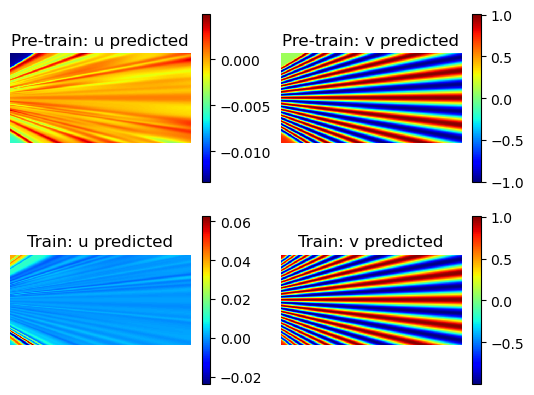

In [15]:
#%% 训练阶段
pretrain_epoch = 2000
train_epoch = 2000
model_train(model, X, Y, pretrain_epoch, train_epoch, 1, 1, new_lr = 0.001)

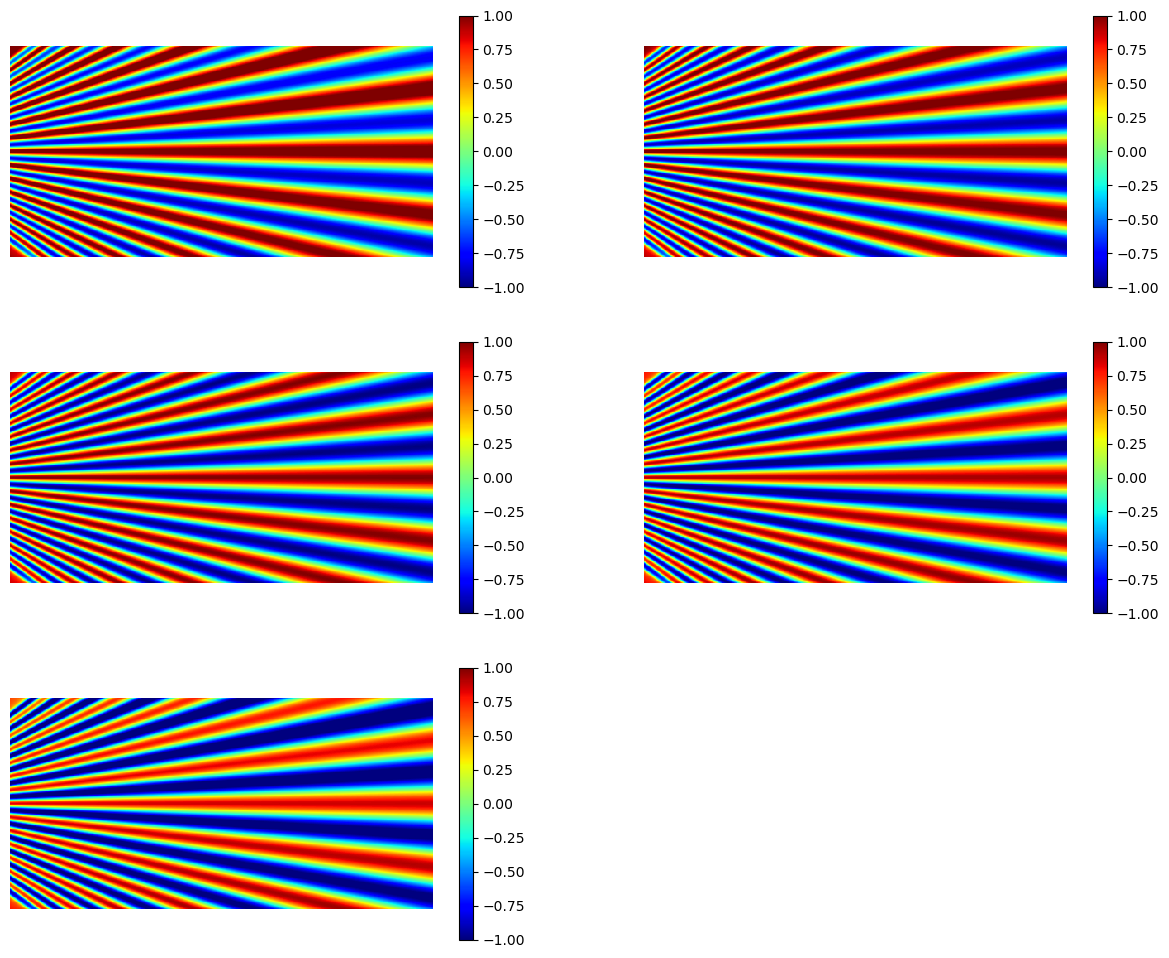

In [11]:
u, v, k, b = model.predict1(X,Y)
plt.figure(figsize=(15, 12))
norm = matplotlib.colors.Normalize(vmin=-1, vmax=1)
plt.subplot(3,2,1)
plt.imshow(v+k[0,1]*(-2), cmap='jet', interpolation='nearest', norm=norm) # +b[0,1]
plt.axis('off')
plt.colorbar()
plt.subplot(3,2,2)
plt.imshow(v+k[0,1]*(-1), cmap='jet', interpolation='nearest', norm=norm) # +b[0,1]
plt.axis('off')
plt.colorbar()
plt.subplot(3,2,3)
plt.imshow(v+k[0,1]*(+0), cmap='jet', interpolation='nearest', norm=norm) # +b[0,1]
plt.axis('off')
plt.colorbar()
plt.subplot(3,2,4)
plt.imshow(v+k[0,1]*(+1), cmap='jet', interpolation='nearest', norm=norm) # +b[0,1]
plt.axis('off')
plt.colorbar()
plt.subplot(3,2,5)
plt.imshow(v+k[0,1]*(+2), cmap='jet', interpolation='nearest', norm=norm) # +b[0,1]
plt.axis('off')
plt.colorbar()

In [53]:
# save_model_param(model, string='star_5_lbd')
# save_model_param(model, string='UT_5')
# save_model_param(model, string='rigid_5')

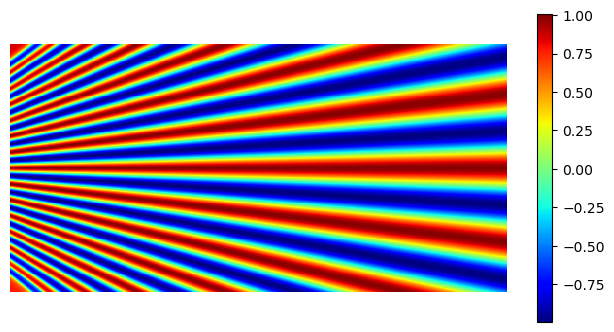

In [16]:
u, v, k, b = model.predict1(X,Y)
plt.figure(figsize=(8, 4))
plt.subplot(1,1,1)
plt.imshow(v, cmap='jet', interpolation='nearest')
plt.axis('off')
plt.colorbar()

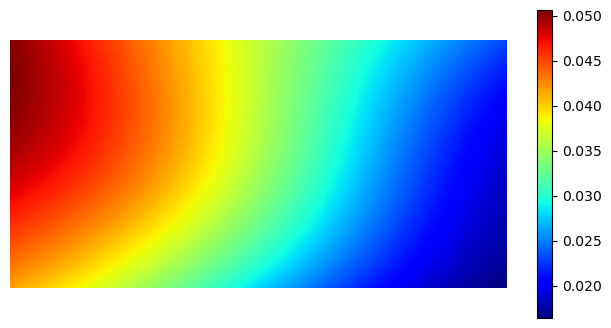

In [56]:
u, v, k, b = model.predict1(X,Y)
plt.figure(figsize=(8, 4))
plt.subplot(1,1,1)
plt.imshow(k[0,1], cmap='jet', interpolation='nearest')
plt.axis('off')
plt.colorbar()